In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented Simple Ensamble Learning ('whighted Averaging') with Decision Tree, Random Forest and KNN 

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

/tmp/ipykernel_2292617/3809934590.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-03 01:21:09.171494: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 01:21:09.203673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 01:

In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

In [3]:
# df = df.sample(frac=0.75)

In [4]:
# Extract subsample of data
print (" Extract subsample of data: ")
print(df['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [5]:
dropped_df = ['ALERT']
X = df.drop(dropped_df, axis=1)
y = df['ALERT']

# # Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(df['ALERT'].value_counts())

ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [6]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Standardize numerical features if necessary (replace with appropriate scaling if needed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models and create VotingClassifier ensemble
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3 = RandomForestClassifier()
ensemble = VotingClassifier(estimators=[('dt', model1), ('knn', model2), ('rf', model3)],
                           voting='hard', weights=[0.4, 0.3, 0.3])  # Experiment with weights

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# Train the models
with strategy.scope():
    ensemble.fit(X_train, y_train)  # Train the ensemble with early stopping 


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-03 01:22:17.492356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46862 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-03 01:22:17.492912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46804 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


In [7]:

# Make predictions
predictions = ensemble.predict(X_test)


In [10]:
# y_pred = np.argmax(predictions, axis=1)
# Evaluate the model (consider using more comprehensive metrics)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
# Final prediction and 0.4 0.3 0.3 weights are used
# and 0.4 0.3 0.3 weights mean that 40% of the weight is given to the first model, 30% to the second model, and 30% to the third model.
finalpred = ((pred1 * 0.4 ) + (pred2*0.3)+(pred3*0.3))

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [13]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(predictions)
y_test_labels = label_encoder.inverse_transform(y_test)

In [14]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00   1027795
          Malware       1.00      1.00      1.00       114
           Normal       1.00      1.00      1.00   3009866
    Port Scanning       1.00      1.00      1.00    834039

         accuracy                           1.00   4871814
        macro avg       1.00      1.00      1.00   4871814
     weighted avg       1.00      1.00      1.00   4871814



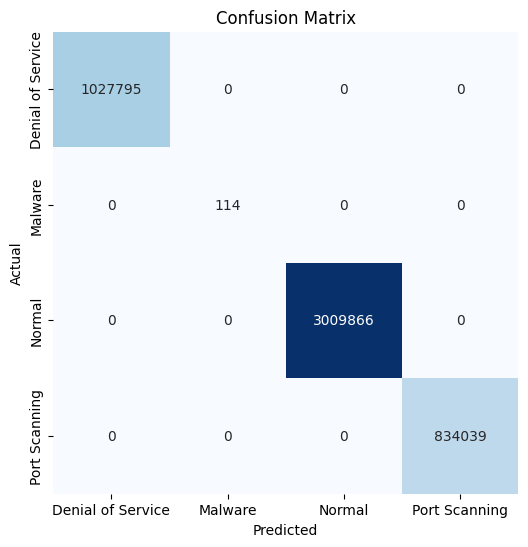

In [15]:
import numpy as np
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()